In [ ]:
The goal of the use case is to find abnormal behaviour. In real word problem, we usually do not have labelled data, and 
also the proportion of the anomalous data  observed or recorded is very less in comparision to the normal data. 
Hence we implemented a techinique which tries to understand or learn normal behaviour such that the model can identify
only the normal behaviour and model will fail to understand the abnormal activity which can then be flagged for further 
analysis for anomaly.

we made use of data from airbus challenge - its a data set consisting of sensor data from flight, out of the entire 
sensor data we had to focus on detecting anomaly on focus/priortise sensors. 

We have made use of LSTM auto encoder. LSTM auto encoder makes use of encoder decoder model, encoder reads in the input
and we have bottleneck part which basically tries to extract the compressed representation which is later used by decoder
to reconstruct the original sequence. 

Since we have sequential time series data , and we wanted exploit the sequential nature we made use of LSTM at the encoder
and decoder end. We trained the model on set of data majorily comprosing of normal behaviour. Later with the help of
reconstuction error at the decoder end , i.e if the reconstruction is above threshold flag it as anomaly otherwise normal
data. The threshold used was 3 std deviatino from the mean. 


## Importing required packages

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#from lstm_vae import create_lstm_vae,create_lstm_autoencoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import keras
from keras.layers import Lambda, Input, LSTM, RepeatVector, TimeDistributed, Dense, Masking
from keras.preprocessing import sequence
from keras import Model
from keras import backend as K
from scipy.stats import multivariate_normal
import glob
from sklearn.model_selection import train_test_split
import random


Using TensorFlow backend.


# Dataset Files preparation

In [2]:
# from competetion - Following files should be disregarded for training and testing:
file_name  = ['C460fdfc5aaf6cde64f8f6786e3387a32.csv',
'C2df4530733e3495a542d0b5cb018397a.csv',
'C755d2706850a150631be858c381d6373.csv',
'Cbc7240c4165f374c77494f5b3cdf0c0c.csv',
'Cb1131586e1539da2f220c7cdf8ccf782.csv',
'B83e2d4650dcbbe9d294093bcfc1d212e.csv',
'Cc19f599a9976291ef81cf6f4efa3a928.csv',
'C7cf6425be6a6cc32ce876ff441eaa180.csv',
'C3c704ee7c53d7a9948480c434b500980.csv',
'Cd1e1e3884b1f28a4828121b5c0db5a68.csv',
'B1b092d3c59cf2c2cdea76464c6f48367.csv',
'C1a51c114de301e8e2776fb815f4f8402.csv',
'Cf27f25da6cf4fd3a10f259951704e9f3.csv',
'Cba730925534594a0145da7e47901e833.csv',
'C9fc038c1f912a6995bf7a38b3e4ae652.csv',
'C6107836a93f158bb1b6248229583e359.csv']


In [3]:
#read the filename to a list
flight_seq = [f.split('/')[-1] for f in glob.glob('./airbus_cac_dataset_unzip/B*') if os.path.isfile(f)]
ground_seq = [f.split('/')[-1]  for f in glob.glob('./airbus_cac_dataset_unzip/C*') if os.path.isfile(f)]

total_file = flight_seq + ground_seq

# removing the files that should be disregarded for training and testing purpose
final_file  = [i for i in total_file if i not in file_name]


In [4]:
#file in which anomaly where detected by the contestant in the competetion, so we would keep this set of file as test data and use
#to see how the model is working on it

test_file = ['Bd1753ba7aa4e2c1a48dd49b132870e4e.csv',
'Bd1753ba7aa4e2c1a48dd49b132870e4e.csv',
'Bd786c443e51ded9ac174507cb7e711c4.csv',
'B9d40e6df4482de35270989d73fc096e4.csv',
'B9d40e6df4482de35270989d73fc096e4.csv',
'B4bab6e3dd3fe27555aa0f628bb1ad108.csv',
'B8291d655fb2c3ccb6cc5dcb4d7730fea.csv',
'Be83abe2d5cb247b107995c60cdc9daef.csv',
'B8b71699d79b1672fcbab205a08f777a7.csv']

final_file  = [i for i in final_file if i not in test_file]


In [5]:
#dividing the data into train and validation set
#while dividing the data to train and val , let us see it to that the flight and ground test gets divided proportionaly

file_prop = np.array([[i,i[0]]for i in final_file])
train_file, val_file = train_test_split(file_prop[:,0], test_size=0.1,stratify = file_prop[:,1])


# Data preparation

#### Data format for LSTM 

In [6]:
## function to prepare the data set in sample, timestep, feature format for lstm
def get_data(dataset, look_back):
    dataX = []
    for i in range(len(dataset)-look_back+1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
    return np.array(dataX)


#### Data pre processing -
Downsampling <br>
Scaling the data 

In [7]:
# function to process the data
def prepare_data(data_name, timestp, col_name_req =False,min_max_scaler_req = False):
    data = pd.read_csv('./airbus_cac_dataset_unzip/'+data_name)
    data.drop('Unnamed: 0',inplace=True,axis = 1)
    #removing parameter_11 as mentioned by the competition
    data.drop(['parameter_11'],inplace=True,axis=1)

    ###########Downsampling################
    median_var = []
    mean_var = []
    for i in data.columns:
        if(len(data[i].unique())<4):
            median_var.append(i)  ## storing the column name with 1 or 2 or 3 unique value
        else:
            mean_var.append(i) ## storing the column name with continous unique value

    down_sampled_data_mean = data[mean_var].groupby(np.arange(len(data))//80).mean()
    down_sampled_data_median = data[median_var].groupby(np.arange(len(data))//80).median()
    down_sampled_data_concat = pd.concat([down_sampled_data_mean,down_sampled_data_median],axis = 1)

    ## rearranging the column name as data
    down_sampled_data = pd.DataFrame()
    initial = True
    for i in data.columns:
        if(initial == True):
            down_sampled_data = down_sampled_data_concat[i]
            initial = False
        else:
            down_sampled_data = pd.concat([down_sampled_data,down_sampled_data_concat[i]],axis = 1)

    ######getting column name ###################
    if(col_name_req == True):
        col_dict = {}
        val = 0
        for i in down_sampled_data.columns:
            col_dict[i] = val
            val = val+1

    #####################scaling the data######################
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_data = min_max_scaler.fit_transform(down_sampled_data.values)

    pd.DataFrame(scaled_data).describe()
    if(len(scaled_data)<timestp):#120
        scaled_data1 = keras.preprocessing.sequence.pad_sequences(maxlen = timestp,#120
                                         sequences=[scaled_data],
                                         value=0.0,
                                         dtype='float',
                                         padding='post')
        data_formated= get_data(scaled_data1[0],timestp)#120

    else:
        data_formated= get_data(scaled_data,timestp)#120

    if(col_name_req == True and min_max_scaler_req == True):
        return(data_formated,col_dict,min_max_scaler)

    elif(col_name_req == True):
        return(data_formated,col_dict)

    elif(min_max_scaler_req == True):
        return(data_formated,min_max_scaler)

    return(data_formated)



### Model Building 

In [8]:
batch_size = 100
early_stopping_çb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.0005,
                                                  patience=2,
                                                  verbose=0,
                                                  mode='auto',
                                                  baseline=None,
                                                  restore_best_weights=False)



def create_lstm_autoencoder(input_dim, timesteps, latent_dim):
    inputs = Input(shape=(timesteps, input_dim))
    inputs_masked = Masking(mask_value=0.)(inputs)
    encoded = LSTM(latent_dim, return_sequences=True)(inputs_masked)

    decoded = LSTM(latent_dim, return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(input_dim))(decoded)

    encoder = Model(inputs, encoded)
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return (encoder, autoencoder)


In [ ]:
# training the model 
input_dim = 89
timesteps = 120
enc, ae = create_lstm_autoencoder(input_dim=input_dim, timesteps=timesteps, latent_dim=30)


for file in train_file:
    data_lstm= prepare_data(file,120)
    input_dim = data_lstm.shape[-1]
    timesteps = data_lstm.shape[1]

    #for i in range(30):
    #    val_file_random = prepare_data(random.choice(val_file))
    #    model_hist = ae.fit(data_lstm, data_lstm, epochs=1,shuffle=False,batch_size = batch_size,
    #                    validation_data = (val_file_random,val_file_random), #https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/
    #                    callbacks = [early_stopping_çb])
        #ae.reset_states()
    val_file_random = prepare_data(random.choice(val_file),120)
    model_hist = ae.fit(data_lstm, data_lstm, epochs=20,shuffle=False,batch_size = batch_size,
                        validation_data = (val_file_random,val_file_random), #https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/
                        callbacks = [early_stopping_çb])

ae.save_weights('my_model_weights.h5')

### Model Testing 

In [9]:
#loading the weights back and testing it on test data
input_dim = 89
timesteps = 120
enc, ae = create_lstm_autoencoder(input_dim=input_dim, timesteps=timesteps, latent_dim=30)

ae.load_weights('my_model_weights.h5')

In [10]:
##removing the timestep aspect
def get_data_reverse(data):
    reverse_data_list = []
    for i in range(len(data)):
        reverse_data_list.append(data[i][0])
        if(i==len(data)-1):
            for j in data[i]:
                reverse_data_list.append(j)
    return(reverse_data_list)

In [11]:
#perform prediction

def perform_pred(filename):
    data_test,col_dict, scale = prepare_data(filename,120,True, True)
    pred_data = ae.predict(data_test)

    min_max_scaler = scale
    pred_data_orig = get_data_reverse(pred_data)
    pred_inverse_orig = min_max_scaler.inverse_transform(pred_data_orig)

    test_data_orig = get_data_reverse(data_test)
    test_inverse_orig = min_max_scaler.inverse_transform(test_data_orig)

    return(data_test,pred_data,test_inverse_orig,pred_inverse_orig,col_dict)

In [12]:
#flagging the record as anomaly if above the thershold
def flag_anomaly(test_inverse,preds_inverse):
    mse = np.linalg.norm(preds_inverse - test_inverse,axis = 1,ord = 2)
    error_df = pd.DataFrame({'reconstruction_error': mse})
    mse_threshold = np.mean(mse) + 3*np.std(mse)
    error_df['flag_anomaly'] = 'N'
    error_df.loc[error_df.reconstruction_error>mse_threshold,'flag_anomaly']='Y'
    error_df['timeRange'] = np.arange(80,80*(len(error_df)+1),80)
    return(error_df,mse_threshold)

In [13]:
data_test,pred_data,test_inverse_orig,pred_inverse_orig,col_dict = perform_pred('Bd786c443e51ded9ac174507cb7e711c4.csv')
anomaly_flaged_dataframe,mse_threshold = flag_anomaly(test_inverse_orig,pred_inverse_orig)

### Visualising the anomaly

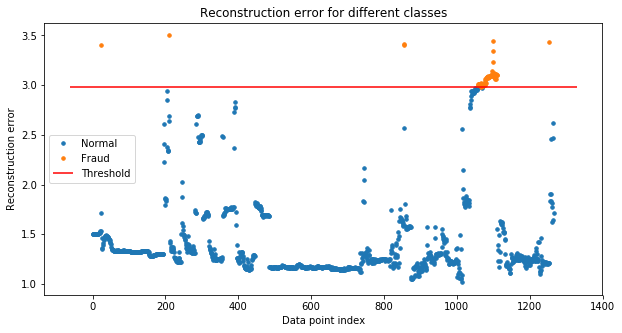

In [14]:
groups = anomaly_flaged_dataframe.groupby('flag_anomaly')
fig, ax = plt.subplots(figsize=(10,5))

for name, group in groups:

    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 'Y' else "Normal")
ax.hlines(mse_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


In [51]:
# extracting and visualising the time period in which anomaly occured
def extract_time_anomaly(error_dataframe,test_inverse_orig,pred_inverse_orig,col_dict):
    error_df = error_dataframe
    time_range = 0
    temp_time_list = []
    time_list = []
    index_list = []
    temp_index_list = []
    for i in range(len(error_df)):
        if(error_df.flag_anomaly[i]=='Y'):
            temp_time_list.append(error_df.timeRange[i])
            temp_index_list.append(error_df.index[i])
        else:
            if(len(temp_time_list)!=0):
                time_list.append([min(temp_time_list),max(temp_time_list)])
                temp_time_list = []

                index_list.append([min(temp_index_list),max(temp_index_list)])
                temp_index_list=[]

    err_val = abs(np.array(test_inverse_orig  - pred_inverse_orig))
    focus_sensor = ['parameter_48','parameter_49','parameter_50','parameter_53','parameter_86','parameter_12','parameter_9','parameter_10']
    col = [[i,col_dict[i]] for i in col_dict.keys() if i in  focus_sensor]

    err_val_focus = pd.DataFrame(err_val[:,[i[1] for i in col]],columns = [i[0] for i in col])

    para_dict = {}
    for i in focus_sensor:
        para_dict[i] = []

    c = 0
    for i in index_list:
        key_val = np.sum(err_val_focus.loc[i[0]:i[1],:],axis = 0).idxmax()
        para_dict[key_val].append([time_list[c][0]-80,time_list[c][1]])
        pd.DataFrame(np.sum(err_val_focus.loc[i[0]:i[1],:],axis = 0)).plot(kind = 'bar',title = 'time_Range'+str((time_list[c][0]-80,time_list[c][1])))
        plt.show()
        c = c+1

    max_l = max([len(x) for x in para_dict.values()])

    for k,val in para_dict.items():
        pad_val = max_l - len(para_dict[k])
        for i in range(pad_val):
            para_dict[k].append([0])

    data_fin = pd.DataFrame(para_dict)
    return(data_fin)


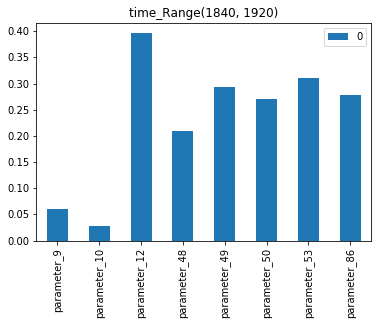

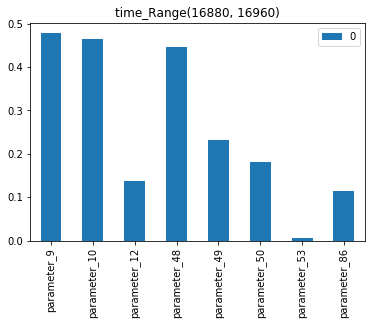

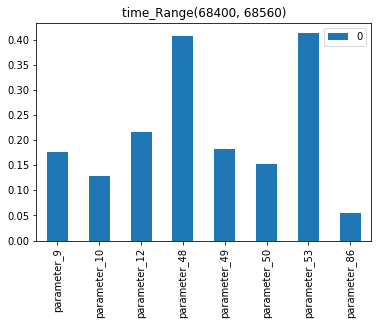

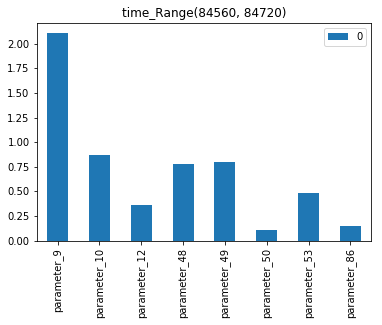

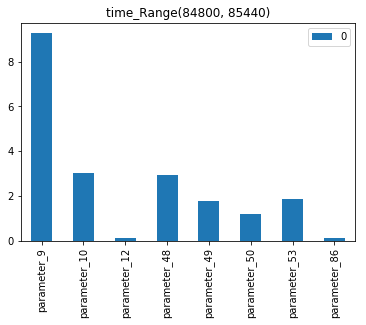

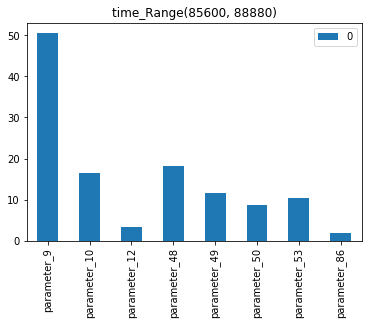

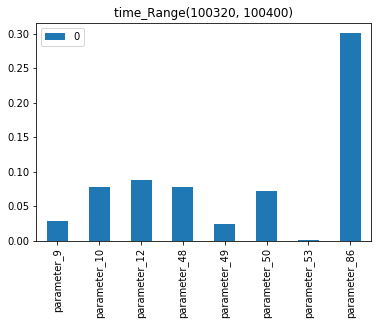

In [54]:
data_fin = extract_time_anomaly(anomaly_flaged_dataframe,test_inverse_orig,pred_inverse_orig,col_dict)

In [55]:
###dataframe with focus sensor
data_fin

,parameter_48,parameter_49,parameter_50,parameter_53,parameter_86,parameter_12,parameter_9,parameter_10
0,[0],[0],[0],"[68400, 68560]","[100320, 100400]","[1840, 1920]","[16880, 16960]",[0]
1,[0],[0],[0],[0],[0],[0],"[84560, 84720]",[0]
2,[0],[0],[0],[0],[0],[0],"[84800, 85440]",[0]
3,[0],[0],[0],[0],[0],[0],"[85600, 88880]",[0]
